# MIE1516 Final Project: Neural Net Control of a Cart and Pole System

## Table of Content

* [1.0 Introduction](#1)
    * [1.1 Motivation](#1.1)
    * [1.2 CartPole Simulation Environment Overview](#1.2)
    * [1.3 Methodology](#1.3)
    * [1.4 Proposed Model Architecture](#1.4)
* [2.0 Utility Funtions](#2)
* [3.0 System Identification](#3)
* [4.0 Controller Design](#4)
* [5.0 Controller Training](#5)
    * [5.1 Generating Data for Controller Training](#5.1)
    * [5.2 Training Controller Models](#5.2)
* [6.0 Controller Testing and Comparision](#6)
    * [6.1 Results Discussion](#6.1)
    * [6.2 Conclusing Remarks](#6.2)
* [7.0 Controller Demo](#7)
* [8.0 References](#8)

## 1.0 Introduction  <a class="anchor" id="1"></a>

### 1.1 Motivation <a class="anchor" id="1.1"></a>

For the control of complex non-linear systems for which there are no analytical design techniques, a neural net can be used to implement highly non-linear controllers with internal parameters that can be determined through a learning process. This control method has the benefit of a “black-box” method, where there is no need to determine the analytical model of the system. The trade-off is that more data is needed, and the system may need to be stressed beyond its idea operating range. 

Reinforcement learning is a type of unsupervised learning algorithm based on a reward and punishment system. The key intent is to simplify the performance indicators of the controlled system. It is difficult to provide rigorous designs and analysis for reinforcement learning in the framework of standard control system theory since the reinforcement signal has reduced information.  

Controller using supervised machine learning algorithms such as a deep neural has two parts. The first is the system identification stage where the neural net model of the system is determined. The second is the controller design stage where a second neural net is trained using the first neural net to achieve the desired reference signal using dynamic backpropagation. This method is commonly called Model Reference Control and has the advantage of being applicable to a large class of non-linear system, but the trade-off is that it is computationally expensive to train [1]. 

Both methods have been shown to perform well using benchmark test models, but not many studies compares the two directly.

In this project, several control using neural net architecture will be compared against an expert reinforcement learning policy in terms of performance and model complexity. The benchmark used in this project will be the Cart and Pole system from OpenAI Gym.

### 1.2 CartPole Simulation Environment Overview <a class="anchor" id="1.2"></a>
- **Reference:** GitHub. (2019). openai/gym. [online] Available at: https://github.com/openai/gym/wiki/CartPole-v0 [Accessed 28 Mar. 2019].
- OpenAI Gym, Greg Brockman and Vicki Cheung and Ludwig Pettersson and Jonas Schneider and John Schulman and Jie Tang and Wojciech Zaremba 2016 

#### Details
* Name: CartPole-v0  
* Category: Classic Control
* [Leaderboard Page](https://github.com/openai/gym/wiki/Leaderboard#cartpole-v0)
* Old links:
  * [Environment Page](https://gym.openai.com/envs/CartPole-v0)  
  * [Algorithms Page](https://gym.openai.com/algorithms?groups=classic_control)

#### Description
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.


#### Observation
Type: Box(4)

Num | Observation | Min | Max
---|---|---|---
0 | Cart Position | -2.4 | 2.4
1 | Cart Velocity | -Inf | Inf
2 | Pole Angle | ~ -41.8&deg; | ~ 41.8&deg;
3 | Pole Velocity At Tip | -Inf | Inf

#### Actions
Type: Discrete(2)

Num | Action
--- | ---
0 | Push cart to the left
1 | Push cart to the right

Note: The amount the velocity is reduced or increased is not fixed as it depends on the angle the pole is pointing. This is because the center of gravity of the pole increases the amount of energy needed to move the cart underneath it

#### Reward
Reward is 1 for every step taken, including the termination step

#### Starting State
All observations are assigned a uniform random value between ±0.05

#### Episode Termination
1. Pole Angle is more than ±12°
2. Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)
3. Episode length is greater than 200

### 1.3 Methodology Overview <a class="anchor" id="1.3"></a>

Tabular Q learning training is found in the file "Q-learning.ipynb". This report covers in depth the neural net control method.

Two neural nets will need to be trained, one for system identification and one for the controller. The goal is to use the first neural net to train the second one to achieve a specific reference signal. The cart and pole system will now be referred as the plant.

**For system identification:**
1. Generate data using the OpenAI gym environment, where random input is fed into the environment and the four output is recorded.
2. Using the data generated, train a neural net that can emulate the behavior of the system. In other words, build a neural net to replace OpenAI gym environment. This is needed as to train the second network, as backpropagation through the plant is needed.

**For controller training:**
1. Generate a set of initial conditions using OpenAI gym.
2. Propose a controller architecture.
3. Feed the initial condition to the controller, then feed the output of the controller (push car to the left or right) to the above plant neural net model to predict the response of the system.
4. Then feed the state of the plant to the controller again and repeat step 3 for a set amount of time steps.
5. Define the loss function: sum((pole_angle - 0)^2), set only the controller parameters as trainable
6. Optimize the controller parameters.

### 1.4 Proposed Model Architecture <a class="anchor" id="1.4"></a>

#### Reinforcement Learning:
1. Tabular Q learning with greedy epsilon strategy (Q learning)

#### Neural Net Controls:
2. 4 Layers Fully Connected (controller_FC) 
3. One directional RNN (controller_RNN) 
4. One directional LSTM (controller_LSTM)

The above controllers will be compared against each other in terms of average pole angle deviation from upright, average cart position deviation from the middle, number of parameters and average runtime for 200 time steps.

In [1]:
import gym
from gym.wrappers import Monitor
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import pickle

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
env = gym.make('CartPole-v0')

## 2.0 Utility Functions  <a class="anchor" id="2"></a>

In [5]:
class Normalizer():
    '''
    Normalize the four state of the CartPole system to have mean 0 and standard deviation 1.
    
    '''
    def __init__(self, mean,std):
        self.mean = mean.cuda()
        self.std = std.cuda()
        
    def normalize(self, data_n):
        return (data_n-self.mean)/self.std
    
    def de_normalize(self,data_n):
        return data_n*self.std+self.mean

In [6]:
def plot_loss(count,loss_graph,scale=2):
    '''
    Plot loss over the number of epochs
    
    '''
    xlabel='Number of Epoch'
    ylabel='Mean Squared Root Error'
    
    width = scale*3.487
    height = width / 1.618

    fig = plt.figure(figsize=(width, height))
    ax = fig.add_subplot(1, 1, 1)
    
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    ax.plot(count, loss_graph,'-')

In [7]:
def plot_performance(expertReward,Title):
    '''
    Plot histogram of reward distribution
    '''
    plt.hist(expertReward,bins=50)
    plt.title(Title + ": Reward Distribution")
    plt.xlabel("Reward")
    plt.ylabel("Frequency")
    unique, counts = np.unique(expertReward, return_counts=True)

In [8]:
def compare_performance(pole_ang,car_pos,num_para,runtimes,models=['Q learning','FC','RNN','LSTM'],scale=2):
    xlabel='Controller Model'
    
    width = scale*2*3.487
    height = width / 1.618
    
    index = np.arange(4)
    bar_width = 2

    fig = plt.figure(figsize=(width, height))
    
    values=[pole_ang,car_pos,num_para,runtimes]
    titles=['Fig 5a. Pole Angle Mean Deviation','Fig 5b. Car Position Mean Deviation','Fig 5c. Number of Parameters','Fig 5d. Runtime (sec)']
    
    for i in range(4):
        ax = fig.add_subplot(2, 2, i+1)
        ax.bar(range(1,5), values[i], alpha=0.5)
        ax.set_title(titles[i])
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(models)

In [9]:
### Functions to run the Q Learning model

def max_dict(d): 
    """
    looking for the action that gives the maximum value for a given state
    """
    max_v = float('-inf')
    for key, val in d.items():
        if val > max_v:
            max_v = val
            max_key = key
    return max_key, max_v

def get_state_as_string(state):
    """
    encoding the state into string as dictionary
    """
    string_state=''
    for e in state:
            string_state = string_state+str(int(e)).zfill(2)
    return string_state

def create_bins(nbins = 10): 
    """
    create bins to discretize the continuous observable state space
    """
    # obs[0] -> cart position --- -4.8 - 4.8
    # obs[1] -> cart velocity --- -inf - inf
    # obs[2] -> pole angle    --- -41.8 - 41.8
    # obs[3] -> pole velocity --- -inf - inf

    bins = np.zeros((4,nbins))
    bins[0] = np.linspace(-4.8, 4.8, nbins)
    bins[1] = np.linspace(-5, 5, nbins)
    bins[2] = np.linspace(-.418, .418, nbins)
    bins[3] = np.linspace(-5, 5, nbins)
    return bins

def assign_bins(observation, bins): 
    """
    discretizing the continuous observation space into state
    """
    state = np.zeros(4)
    for i in range(4):
        state[i] = np.digitize(observation[i], bins[i])
    return state

def play_policy_Q(bins,Q,N=1000,render=False,delay=0.01):
    """
    run an environment using a trained policy
    """
    
    totalReward=[]
    pole_ang_MSE=0
    car_pos_MSE=0
    steps=[]
    start = time.time()
    
    for n in range(N):
        observation=env.reset()
        done=False
        episodeReward=0
        angle_dev=[]
        car_dev=[]
        while not done:
            if render:
                env.render()
                time.sleep(delay)
            state=get_state_as_string(assign_bins(observation, bins))
            act=max_dict(Q[state])[0]
            observation,reward,done,_=env.step(act)
            episodeReward+=reward
            angle_dev.append(float(observation[2]))
            car_dev.append(float(observation[0]))
            
        totalReward.append(episodeReward)
        pole_ang_MSE+=sum(map(abs, angle_dev))/len(angle_dev)
        car_pos_MSE+=sum(map(abs, car_dev))/len(car_dev)
        
    env.close()
    end = time.time()
    
    return totalReward, pole_ang_MSE/N*57.2958,car_pos_MSE/N,end-start

In [10]:
def play_policy(controller,normalizer,N=1000,render=False,delay=0.01,hidden_on=True):
    """
    run an environment using a trained controller
    """
    
    totalReward=[]
    pole_ang_MSE=0
    car_pos_MSE=0
    
    start = time.time()
    
    for n in range(N):
        
        observation=env.reset()
        done=False
        episodeReward=0
        angle_dev=[]
        car_dev=[]
        
        if hidden_on:
            hidden_c = controller.init_hidden(1)
        
        while not done:
            if render:
                env.render()
                time.sleep(delay)
                
            predict=Variable(normalizer.normalize(torch.FloatTensor(observation).unsqueeze(0).unsqueeze(0).cuda()))
            
            if hidden_on:
                hidden_c,act_c=controller(predict,hidden_c)
            else:
                act_c=controller(predict)
            
            if float(act_c[0,0,0].detach().cpu()) > 0.5:
                act = 1
            else:
                act = 0
            
            observation,reward,done,_=env.step(int(act))
            episodeReward+=reward
            angle_dev.append(float(observation[2]))
            car_dev.append(float(observation[0]))
            
        totalReward.append(episodeReward)
        pole_ang_MSE+=sum(map(abs, angle_dev))/len(angle_dev)
        car_pos_MSE+=sum(map(abs, car_dev))/len(car_dev)
        
    env.close()
    
    end = time.time()
    
    return totalReward, pole_ang_MSE/N*57.2958,car_pos_MSE/N, end-start

In [11]:
def wrap_env(env, save_path):
  env = Monitor(env, save_path, force=True)
  return env

## 3.0 System Identification  <a class="anchor" id="3"></a>

Two architectures were investigated in system identification step: RNN and LSTM. The detail of the training can be found in the file "System identification.ipynb". The models were chosen because this was a time-series modeling and repeated computation was needed on variable input size. 

The input was the controller actions: push car left or right.

The outputs were the four states: pole angle and velocity, cart position and velocity.

The models were:
- One directional RNN (Input=1,Output=4, Hidden States = 8, layers = 3)
- One directional LSTM (Input=1,Output=4, Hidden States = 8, layers = 3)

It was found the LSTM model predicted the dynamics munch better than the RNN model: 
- RNN model testing MSE: 0.018
- LSTM model testing MS: 0.001

The LSTM model error is ten times less than the RNN model. This is probably because the time response of non-linear dynamical system depends a lot on past values and not just the immediate past. It is known that RNN model can only use the immediate past whereas the LSTM model is able to store longer memory. There might be some dynamics in the system which have large time lags and thus the LSTM model was a better choice. As a result, for all controller training, the LSTM model will be use as the plant emulator.

In [12]:
class plant_LSTM(nn.Module):
    def __init__(self, output_size = 4, input_size = 1, hidden_size = 8, num_layers = 3):
        super(plant_LSTM,self).__init__()
        
        self.output_size = output_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm=nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size,batch_first=True,num_layers=self.num_layers)
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, x, hidden):
        
        out, hidden = self.lstm(x,hidden)
        out = self.fc(out)

        return hidden, out
    
    def init_hidden(self, init_state):
        
        zeros=torch.zeros([self.num_layers-1,init_state.size(0), self.hidden_size], dtype=torch.float32).cuda()
        mid=torch.cat((init_state,init_state),dim=1).unsqueeze(0)
        
        h_0=Variable(torch.cat((mid,zeros),dim=0))
        c_0=torch.zeros([self.num_layers, init_state.size(0),self.hidden_size], dtype=torch.float32).cuda()
        
        return (h_0,c_0)

In [13]:
#Load Plant Emulator Model
PATH = 'Models/model_plant_LSTM'
model_plant_LSTM = plant_LSTM()
model_plant_LSTM.load_state_dict(torch.load(PATH))
model_plant_LSTM.cuda()

plant_LSTM(
  (lstm): LSTM(1, 8, num_layers=3, batch_first=True)
  (fc): Linear(in_features=8, out_features=4, bias=True)
)

## 4.0 Controller Design <a class="anchor" id="4"></a>

Three controller architecture are investigated:
1. Fully Connected:
    - Tanh(Input->8)
    - Tanh(8->16)
    - Tanh(16->32)
    - Tanh(32->1)
    - Sigmoid(1->Output)
2. One directional RNN (Input=4,Output=1, Hidden States = 2, layers = 1)
3. One directional LSTM (Input=1,Output=4, Hidden States = 3, layers = 2)

The FC network was performing consistently over multiple tries, and thus no grid search was performed. For the RNN and LSTM model, grid search was performed over the number of hidden states and layers. The numbers above shows the optimal hyperparameters found. 

In [14]:
class controller_FC(nn.Module):
    def __init__(self,output_size = 1, input_size = 4, num_layers = 4, node_exp = 2):
        
        super(controller_FC,self).__init__()
        
        self.output_size = output_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.node_exp = node_exp
        
        h_sizes=[self.input_size]
        mul=self.input_size
        for i in range(self.num_layers):
            mul=mul*self.node_exp
            h_sizes.append(int(mul))
        
        self.hidden = nn.ModuleList()
        for k in range(len(h_sizes)-1):
            self.hidden.append(nn.Linear(h_sizes[k], h_sizes[k+1]))
            
        self.fc_last = nn.Linear(h_sizes[-1], self.output_size)
        
        self.tanh = nn.Tanh()
        self.sig=nn.Sigmoid()
        
    def forward(self, x):
        
        out=x
        for i,l in enumerate(self.hidden):
            out = self.tanh(l(out))
        out = self.sig(self.fc_last(out))
        
        return out

In [15]:
class controller_RNN(nn.Module):
    def __init__(self,output_size = 1, input_size = 4, hidden_size = 1, num_layers = 3):
        
        super(controller_RNN,self).__init__()
        
        self.output_size = output_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn=nn.RNN(input_size=input_size, hidden_size=hidden_size,batch_first=True,num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sig=nn.Sigmoid()
        
    def forward(self, x,hidden):
        
        out, hidden = self.rnn(x,hidden)
        out = self.fc(out)
        out = self.sig(out)
        
        return hidden, out
    
    def init_hidden(self,size):
        
        return torch.zeros([self.num_layers, size,self.hidden_size], dtype=torch.float32).cuda()

In [16]:
class controller_LSTM(nn.Module):
    def __init__(self,output_size = 1, input_size = 4, hidden_size = 1, num_layers = 3):
        
        super(controller_LSTM,self).__init__()
        
        self.output_size = output_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm=nn.LSTM(input_size=input_size, hidden_size=hidden_size,batch_first=True,num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sig=nn.Sigmoid()
        
    def forward(self, x, hidden):
        
        out, hidden = self.lstm(x,hidden)
        out = self.fc(out)
        out = self.sig(out)
        
        return hidden, out
    
    def init_hidden(self,size):
        zeros = torch.zeros([self.num_layers, size,self.hidden_size], dtype=torch.float32).cuda()
        return (zeros,zeros)

## 5.0 Controller Training  <a class="anchor" id="5"></a>

The three proposed controllers are trained using 10000 initial conditions generated from running OpenAI GYM. 

Then they are tested using over 5000 runs using OpenAI GYM to obtain average performance.

In [17]:
def train_controller(model_controller,model_plant,init_cond_data_n,hidden_on=True,alpha=0.0, init_lr=0.005,N=2001,sequence_length=15):
    
    criterion = nn.MSELoss()
    
    #Only set the controller NN parameters as trainable.
    optimizer = torch.optim.Adam(model_controller.parameters(), lr=init_lr)

    count=[]
    loss_graph=[]

    y_target = torch.zeros(batch_size).cuda()

    for epoch in range(N):

        model_controller.zero_grad()
        loss=0
        
        # If the controller model has hidden parameters, then initialize them
        if hidden_on:
            hidden_c = model_controller.init_hidden(batch_size)
        
        #Initialize the starting state of the Cart and Pole
        predict = init_cond_data_n
        hidden_p = model_plant.init_hidden(init_cond_data_n.view(batch_size,-1))

        for i in range(sequence_length):
            
            # Feed the state of the cart and pole into the controller NN to obtain controller action
            if hidden_on:
                hidden_c,act = model_controller(predict,hidden_c)
            else:
                act = model_controller(predict)
            
            # Feed the controller action to the plant NN to obtain a prediction of the system responce
            hidden_p,predict=model_plant(act,hidden_p)
            
            #define the loss function to be the deviation of the pole from upright position
            loss+=criterion(predict[:,0,2],y_target)
        
        if epoch % 100 == 0:
            clear_output(wait=True)
            print("epoch: %d, loss: %1.5f" % (epoch + 1, loss.data))
            
        count.append(epoch)
        loss_graph.append(loss.data)
        
        #Backpropagate and optimize the controller parameters to acheive optimal control
        loss.backward()
        optimizer.step()
    
    return count, loss_graph

### 5.1 Generating Data for Controller Training <a class="anchor" id="5.1"></a>

In [18]:
#Loading the mean and std from plant NN for normalization
normalizer_open = open('Models/normalizer', 'rb') 
normalizer=pickle.load(normalizer_open)

In [19]:
batch_size = 10000

init_cond_data = []
j=0

while not j>= batch_size:
    
    observation = env.reset()
    
    if observation.tolist() not in init_cond_data:
        init_cond_data.append(observation.tolist())
        j=j+1

In [20]:
init_cond_data_t=torch.FloatTensor(init_cond_data).unsqueeze(1).cuda()
init_cond_data_n = Variable(normalizer.normalize(init_cond_data_t))
print(init_cond_data_n.shape)

torch.Size([10000, 1, 4])


### 5.2 Training Controller Models <a class="anchor" id="5.2"></a>

In [21]:
# Set this to True if wishing to perform grid search 
Gridsearch= True
# Set this to True if wishing to train models, otherwise model will be loaded from the "Models" folder
Training = True

#### Fully Connected NN Controller with Grid Search

Optimal hyperparameters found by grid search over nodes multiply ratio of 1 to 2.5 and number of layers range of 2 to 5 is (1,3) for nodes multiply and number of layers respectively. The optimal hyperparameters were then used for the final training. The final FC structure is:
- tanh(FC(4->4))
- tanh(FC(4->4))
- tanh(FC(4->1))

In [22]:
if Gridsearch:
    key=[]
    gridsearch_loss_FC=[]
    for i in [1,1.5,2,2.5]:
        for y in range(4):
            model_controller_FC = controller_FC(node_exp=i,num_layers=y+1).cuda()
            count,loss_graph = train_controller(model_controller_FC,model_plant_LSTM,init_cond_data_n,hidden_on=False,N=1501)
            TotalReward, pole_ang_MSE, car_pos_MSE,runtime = play_policy(model_controller_FC,normalizer,N=5000,hidden_on=False)
            key.append([i,y+1])
            gridsearch_loss_FC.append(pole_ang_MSE)
            
    FC_op= key[gridsearch_loss_FC.index(min(gridsearch_loss_FC))]          
    print(FC_op)

epoch: 1501, loss: 0.19109
[1, 2]


epoch: 2001, loss: 0.20698
controller_FC(
  (hidden): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
    (1): Linear(in_features=4, out_features=4, bias=True)
  )
  (fc_last): Linear(in_features=4, out_features=1, bias=True)
  (tanh): Tanh()
  (sig): Sigmoid()
)


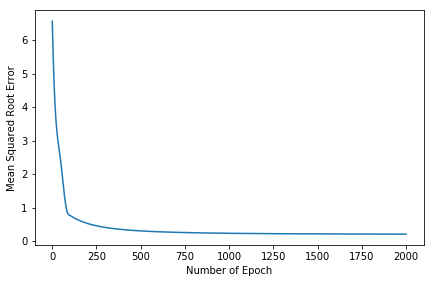

In [23]:
model_controller_FC = controller_FC(node_exp=FC_op[0],num_layers=FC_op[1])
model_controller_FC.cuda()


PATH = 'Models/model_controller_FC'

if Training:
    #Train controller is training is true
    count,loss_graph = train_controller(model_controller_FC,model_plant_LSTM,init_cond_data_n,hidden_on=False)
    print(model_controller_FC)
    #Plot loss over the number of epoches
    plot_loss(count,loss_graph)
    #save model
    torch.save(model_controller_FC.state_dict(), PATH)

else:
    #Load model is not wishin to train
    model_controller_FC.load_state_dict(torch.load(PATH))

#### RNN Controller with Grid Search

Optimal hyperparameters found by grid search over hidden size range of 1 to 8 and number of layers range of 1 to 3 is (2,3) for hidden size and number of layers respectively. The optimal hyperparameters were then used for the final training.

In [24]:
if Gridsearch:
    key=[]
    gridsearch_loss_RNN=[]
    for i in range(8):
        for y in range(3):
            model_controller_RNN = controller_RNN(hidden_size=i+1,num_layers=y+1).cuda()
            count,loss_graph = train_controller(model_controller_RNN,model_plant_LSTM,init_cond_data_n,N=1501)
            TotalReward, pole_ang_MSE, car_pos_MSE,runtime = play_policy(model_controller_RNN,normalizer,N=5000,hidden_on=True)
            key.append([i+1,y+1])
            gridsearch_loss_RNN.append(pole_ang_MSE)
            
    RNN_op= key[gridsearch_loss_RNN.index(min(gridsearch_loss_RNN))]       
    print(RNN_op)

epoch: 1501, loss: 0.18896
[2, 3]


epoch: 2001, loss: 0.19746
controller_RNN(
  (rnn): RNN(4, 2, num_layers=3, batch_first=True)
  (fc): Linear(in_features=2, out_features=1, bias=True)
  (sig): Sigmoid()
)


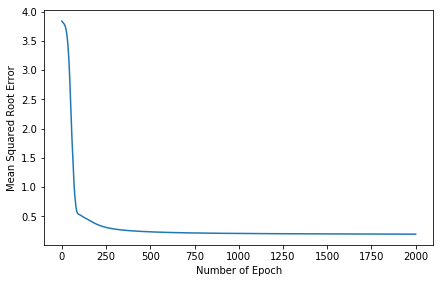

In [25]:
model_controller_RNN = controller_RNN(hidden_size=RNN_op[0],num_layers=RNN_op[1])
model_controller_RNN.cuda()

PATH = 'Models/model_controller_RNN'
        
if Training:
    #Train controller is training is true
    count,loss_graph = train_controller(model_controller_RNN,model_plant_LSTM,init_cond_data_n)
    print(model_controller_RNN)
    #Plot loss over the number of epoches
    plot_loss(count,loss_graph)
    #save model
    torch.save(model_controller_RNN.state_dict(), PATH)

else:
    #Load model is not wishin to train
    model_controller_RNN.load_state_dict(torch.load(PATH))

#### LSTM Controller with Grid Search

Optimal hyperparameters found by grid search over hidden size range of 1 to 8 and number of layers range of 1 to 3 is (3,2) for hidden size and number of layers respectively. The optimal hyperparameters were then used for the final training.

In [26]:
if Gridsearch:
    key=[]
    gridsearch_loss_LSTM=[]
    for i in range(8):
        for y in range(3):
            model_controller_LSTM = controller_LSTM(hidden_size=i+1,num_layers=y+1)
            model_controller_LSTM.cuda()
            count,loss_graph = train_controller(model_controller_LSTM,model_plant_LSTM,init_cond_data_n,N=1501)
            key.append([i+1,y+1])
            TotalReward, pole_ang_MSE, car_pos_MSE,runtime = play_policy(model_controller_LSTM,normalizer,N=5000,hidden_on=True)
            gridsearch_loss_LSTM.append(pole_ang_MSE)
            
    LSTM_op= key[gridsearch_loss_LSTM.index(min(gridsearch_loss_LSTM))]      
    print(LSTM_op)

epoch: 1501, loss: 0.18835
[1, 2]


epoch: 2001, loss: 0.22260
controller_LSTM(
  (lstm): LSTM(4, 1, num_layers=2, batch_first=True)
  (fc): Linear(in_features=1, out_features=1, bias=True)
  (sig): Sigmoid()
)


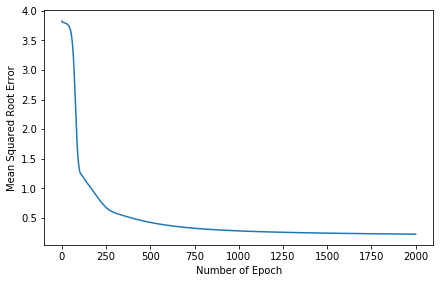

In [27]:
model_controller_LSTM = controller_LSTM(hidden_size=LSTM_op[0],num_layers=LSTM_op[1])
model_controller_LSTM.cuda()

PATH = 'Models/model_controller_LSTM'

if Training:
    
    count,loss_graph = train_controller(model_controller_LSTM,model_plant_LSTM,init_cond_data_n)
    print(model_controller_LSTM)
    plot_loss(count,loss_graph)
    torch.save(model_controller_LSTM.state_dict(), PATH)

else:
    model_controller_LSTM.load_state_dict(torch.load(PATH))

## 6.0 Controller Testing and Comparasion  <a class="anchor" id="6"></a>

In [28]:
# The four metrics that will be used to compare the four controllers
pole_ang=[]
car_pos=[]
num_para=[]
runtimes=[]

### Loading and testing the Q learning reinforcement learning algorithm.

The Q learning algorithm loads a lookup table, where the four continuous state variables are divided into bins. For each combination of states, the lookup table will give you the action with the highest probability to generate better rewards. At each timestep, you can look up the state in the Q table, and choose the action with the highest probability.

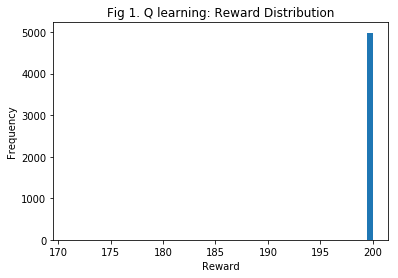

In [29]:
#Load Q learning table from the saved models
bins=create_bins()
expert_Q_open = open('Models/expert_Q', 'rb') 
expert_Q=pickle.load(expert_Q_open)

TotalReward, pole_ang_MSE, car_pos_MSE,runtime=play_policy_Q(bins,expert_Q,N=5000,render=False)
plot_performance(TotalReward,"Fig 1. Q learning")
pole_ang.append(pole_ang_MSE)
car_pos.append(car_pos_MSE)
num_para.append(len(expert_Q))
runtimes.append(runtime)

#### Testing the Fully Connected NN Controller

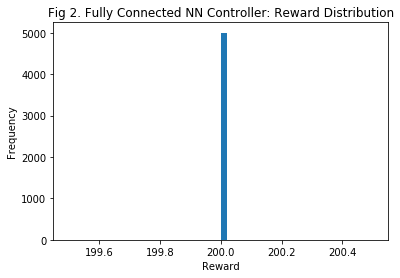

In [30]:
TotalReward, pole_ang_MSE, car_pos_MSE,runtime = play_policy(model_controller_FC,normalizer,N=5000,hidden_on=False)
plot_performance(TotalReward,"Fig 2. Fully Connected NN Controller")
pole_ang.append(pole_ang_MSE)
car_pos.append(car_pos_MSE)
num_para.append(sum(p.numel() for p in model_controller_FC.parameters()))
runtimes.append(runtime)

#### Testing the RNN Controller

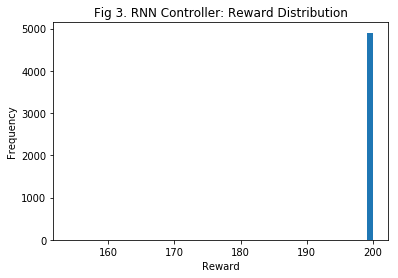

In [31]:
TotalReward, pole_ang_MSE, car_pos_MSE,runtime = play_policy(model_controller_RNN,normalizer,N=5000,hidden_on=True)
plot_performance(TotalReward,'Fig 3. RNN Controller')
pole_ang.append(pole_ang_MSE)
car_pos.append(car_pos_MSE)
num_para.append(sum(p.numel() for p in model_controller_RNN.parameters()))
runtimes.append(runtime)

#### Testing the LSTM Controller

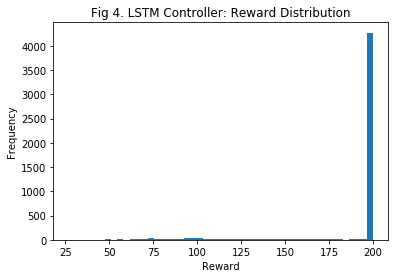

In [32]:
TotalReward, pole_ang_MSE, car_pos_MSE,runtime = play_policy(model_controller_LSTM,normalizer,N=5000,hidden_on=True)
plot_performance(TotalReward,'Fig 4. LSTM Controller')
pole_ang.append(pole_ang_MSE)
car_pos.append(car_pos_MSE)
num_para.append(sum(p.numel() for p in model_controller_LSTM.parameters()))
runtimes.append(runtime)

#### Compare the performance of the Controller

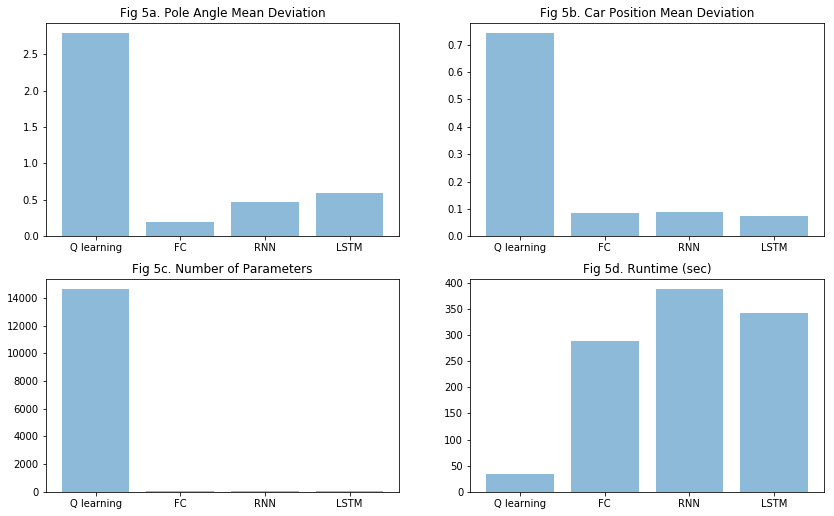

In [33]:
compare_performance(pole_ang,car_pos,num_para,runtimes)

### 6.1 Results Discussion <a class="anchor" id="6.1"></a>

From Figure 1 to 4, for 500 test runs, all four controllers were able to pass the objective apart from the LSTM controller. In other words, apart from the LSTM controller, all other three were able to keep the pole upright for 200 timesteps. Even with grid search, the LSTM controller was not able to meet the objectives. This means that the LSTM architecture in this case, was not well suited for this controller.  This shows that the controller itself was not a time dependent dynamical system and was simply a non-linear function that could be approximated using a FC or RNN network.

Comparing the other three controllers, the FC controller excel at all of the metrics. Out of the three, it has the lowest MSE for pole angle and car position based on Figure 5a and 5b. Even though car deviation from the middle was not a required objective, it was interesting to look at as it showed the amount of effort needed to keep the pole upright, which could be a secondary objective for this system.

For the number of parameters, because the Q learning algorithm was storing a look up table, it required the largest number of parameters, but it also gave the shortest computational time since it used a lookup function. As a result, for the three controllers, it was a trade-off between memory storage and computational time. The best model for the controller was the FC and RNN model. Both performed very similarly, with the FC model being slightly better in terms of angle deviation error and runtime.

### 6.2 Conclusing Remarks <a class="anchor" id="6.2"></a>

It is worthy to note that the reinforcement learning algorithm used in this case is a very simple one. There are much more advance algorithms that were not investigated in this report. This report focused mostly on using different neural net for controls.

Based on the algorithm investigated, for the fully actuated non-linear control system like the CartPole example, the LSTM model is the most well suited for system identification, while the FC model performed the best for constant reference signal tracking. 

During this project, it was found that the performance of the controller is very dependent on the quality and amount of data obtained on the real system. In this case, the "real" system was an OpenAI GYM environment with no friction and relatively speaking simple dynamics. For more complicated systems with larger number of states and inputs, it is expected that more data and time is needed to train larger networks to achieve good controller performance. 

Nevertheless, neural network has a very promising role in non-linear control as it can be used as a black box method to approximate complex controllers and emulate complex dynamical systems that may not have an analytical solution as shown in this project.

## 7.0 Controller Demo <a class="anchor" id="7"></a>

Record and save videos of the controller in action for the rendered OpenAI GYM environment. 

In [34]:
save_path = 'Controller_Demo/expert_Q'
env = wrap_env(gym.make('CartPole-v0'),save_path)
TotalReward, pole_ang_MSE, car_pos_MSE,runtime=play_policy_Q(bins,expert_Q,N=1,render=True,delay=0.05)

In [35]:
save_path = 'Controller_Demo/model_controller_FC'
env = wrap_env(gym.make('CartPole-v0'),save_path)
TotalReward, pole_ang_MSE, car_pos_MSE,runtime=play_policy(model_controller_FC,normalizer,N=1,render=True,delay=0.05,hidden_on=False)

In [36]:
save_path = 'Controller_Demo/model_controller_RNN'
env = wrap_env(gym.make('CartPole-v0'),save_path)
TotalReward, pole_ang_MSE, car_pos_MSE,runtime=play_policy(model_controller_RNN,normalizer,N=1,render=True,delay=0.05,hidden_on=True)

In [37]:
save_path = 'Controller_Demo/model_controller_LSTM'
env = wrap_env(gym.make('CartPole-v0'),save_path)
TotalReward, pole_ang_MSE, car_pos_MSE,runtime=play_policy(model_controller_LSTM,normalizer,N=1,render=True,delay=0.05,hidden_on=True)

## 8.0 references  <a class="anchor" id="8"></a>

- [1] M. T. Hagan, H. B. Demuth and O. D. Jesus, "An Introduction to the Use of Neural Networks in Control Systems," International Journal of Robust and Nonlinear Control, Vol 12, Issue 11, 2002. 
- GitHub. (2019). openai/gym. [online] Available at: https://github.com/openai/gym/wiki/CartPole-v0 [Accessed 28 Mar. 2019].
- OpenAI Gym, Greg Brockman and Vicki Cheung and Ludwig Pettersson and Jonas Schneider and John Schulman and Jie Tang and Wojciech Zaremba 2016 
- Conyngham, P. (2018). Rendering OpenAi Gym in Google Colaboratory. [Blog] StarAI Applied Research Blog. Available at: https://star-ai.github.io/Rendering-OpenAi-Gym-in-Colaboratory/ [Accessed 26 Mar. 2019].
-   Phil Tabor, OpenAI-Cartpole, (2017), GitHub repository, https://github.com/philtabor/OpenAI-Cartpole
